In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
import tensorflow_privacy
from typing import Tuple
from utils import make_deterministic

make_deterministic()
plt.rcParams['font.size'] = 22

dtype = np.float64
gpflow.config.set_default_float(dtype)

gpus = tf.config.list_physical_devices('GPU')
print("\n GPU", gpus)
try:
  tf.config.experimental.set_memory_growth(gpus[0], True)
except:
  print("Couldn't set flexible memory growth, found GPU", gpus)


 GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Let's generate some synthetic training data ...

In [3]:
save_figs=True
N = 5_000  # Number of training observations
def func(x):
    return np.sin(x * 6) + 0.3 * np.cos(x * 2) + 0.5 * np.sin(15*x)

X = np.random.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * np.random.randn(N, 1)  # Noisy Y values
X = X.astype(dtype)
Y = Y.astype(dtype)

n_test = 750
idx=1_900
sorted_ids = np.argsort(X, axis=0).flatten()
test_idx = sorted_ids[idx-(n_test//2): idx+(n_test//2)]
train_idx = main_list = list(set(sorted_ids) - set(test_idx))

X_train, y_train = X[train_idx], Y[train_idx]
X_test, y_test = X[test_idx], Y[test_idx]
print(len(X_train), len(X_test))

4250 750


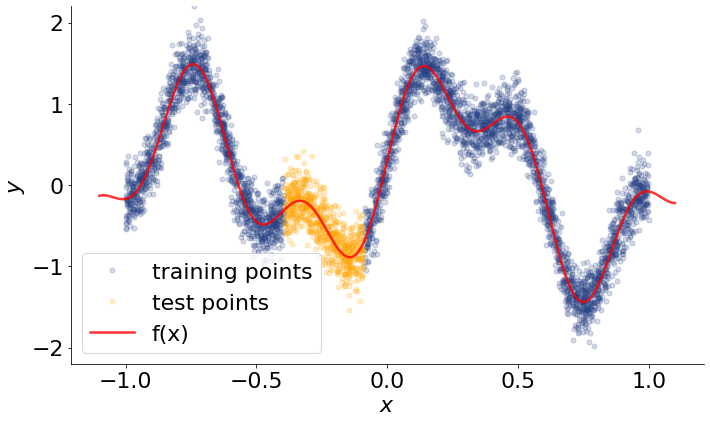

In [4]:
plt.figure(figsize=(10, 6))
ylim=(-2.2, 2.2)
plt.plot(X_train, y_train, ".", label="training points", alpha=0.2, markersize='10',color='#264185')
plt.plot(X_test, y_test, ".", label="test points", alpha=0.2, markersize='10',color='orange')
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
_ = plt.plot(Xt, Yt, alpha=0.8, lw=2.5, c='red', label='f(x)')
sns.despine()
plt.legend()
plt.tight_layout()
plt.ylim(ylim)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig("figures/dp_vfe/underlying_func.pdf") if save_figs else 0

In [5]:
from dp_gp.approximate_inference.common_train_logic import make_SVGP_model, simple_training_loop
n_inducing = 100
Z = np.random.uniform(-1, 1, size=(n_inducing, 1))
k = gpflow.kernels.SquaredExponential()
m = make_SVGP_model(num_inducing=n_inducing, num_data=len(X), Z_init=Z, kernel=k, num_features=1)
m

2022-08-22 15:37:35.993778: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


name,class,transform,prior,trainable,shape,dtype,value
SVGP_psg.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP_psg.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP_psg.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP_psg.inducing_variable.Z,Parameter,Identity,,False,"(100, 1)",float64,[[-6.23215283e-02...
SVGP_psg.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0....
SVGP_psg.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."


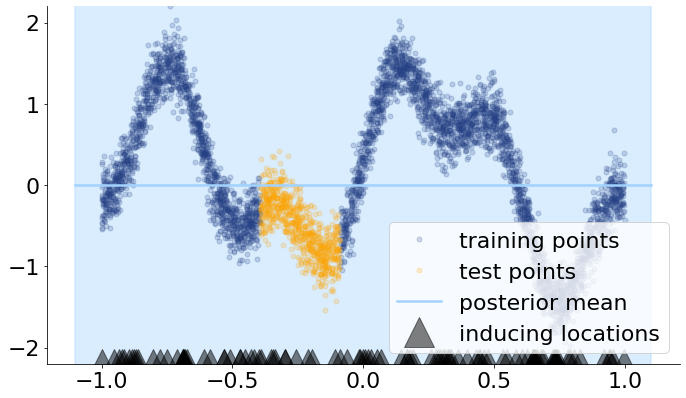

In [6]:
from utils import plot_model

plot_model(m, (X_train, y_train), (X_test, y_test), is_svgp=True, title="")
plt.savefig("figures/dp_vfe/svgp_prior.pdf") if save_figs else 0

In [7]:
from dp_gp.approximate_inference.dp_gd_optimizer import VectorizedDPKerasAdamOptimizer

BATCH_SIZE = 128
EPOCHS = 70
L2_CLIP = 10.0
NOISE_MULT = 2.75
LR = 1e-2
delta = round(1/(N-n_test), 5)

DP=True

if DP:
        print("using private optimizer")
        opt = VectorizedDPKerasAdamOptimizer(
                l2_norm_clip=L2_CLIP,
                noise_multiplier=NOISE_MULT,
                num_microbatches=BATCH_SIZE,
                learning_rate=LR,
        )
else:
        print("using non private optimizer")
        opt = tf.keras.optimizers.Adam(learning_rate=LR)

using private optimizer


In [8]:
log_freq = 25
*_, elbos_scaled, norm_vals = simple_training_loop(
            model=m,
            data=(X_train, y_train),
            optimizer=opt,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            logging_batch_freq=log_freq,
            apply_dp=DP,
            track_psg_norms=True)

loss: 73.476 ELBO: -74.020, ELBO (scaled): -689.2236003081813: 100%|██████████| 2310/2310 [01:41<00:00, 22.80it/s] 


### Computing differential privacy guarantee


In [9]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
eps, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=N-n_test,
                                              batch_size=BATCH_SIZE,
                                              noise_multiplier=NOISE_MULT,
                                              epochs=EPOCHS,
                                              delta=delta)
eps = np.inf if not DP else eps
print(eps)

DP-SGD with sampling rate = 3.01% and noise_multiplier = 2.75 iterated over 2325 steps satisfies differential privacy with eps = 1.98 and delta = 0.00024.
The optimal RDP order is 7.0.
1.9772577051313724


## Plot predictions

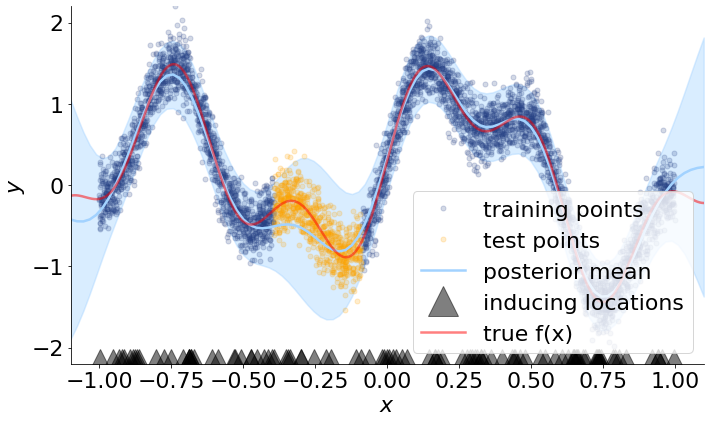

In [10]:
plot_model(m, (X_train, y_train), (X_test, y_test), is_svgp=True, predict_y=True)
plt.plot(Xt, Yt, c="red", alpha=0.5, lw=2.5, label='true f(x)')
plt.legend(loc="lower right")
plt.xlabel("$x$")
plt.ylabel("$y$")
mode = "private" if DP else "non-private"
plt.savefig(f"figures/dp_vfe/svgp_posterior_{mode}.pdf") if save_figs else 0
plt.xlim((-1.1, 1.1))
plt.show()

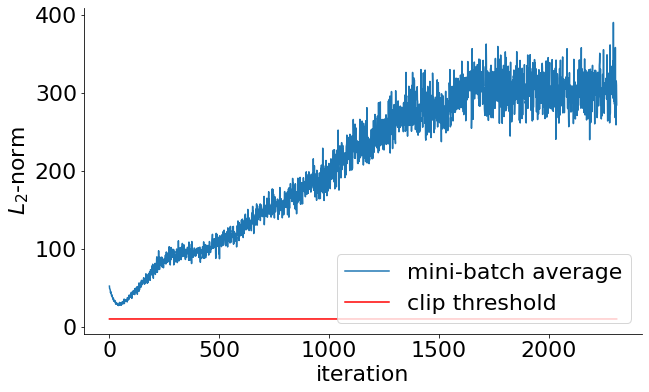

In [15]:
if norm_vals[0] is not None:
    plt.figure(figsize=(10, 6))
    plt.plot([np.mean(n) for n in norm_vals], label='mini-batch average') 
    plt.ylabel("$L_2$-norm")
    plt.xlabel("iteration")
    plt.plot(np.repeat(L2_CLIP,len(norm_vals)) , label='clip threshold', c='red')
    sns.despine()
    plt.legend(loc="lower right")
    plt.savefig(f"figures/dp_vfe/average_norms.pdf") if save_figs else 0